In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

# GPU:
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3 MB 20 kB/s 
     |████████████████████████████████| 12.7 MB 28.5 MB/s 
     |████████████████████████████████| 7.6 MB 10.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.11.0+cu113
    Uninstalling torchaudio-0.11.0+cu113:
      Successfully uninstalled torchaudio-0.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torc

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [ ]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
print(waveform.max())
print(sample_rate)
print(label)
print(speaker_id)
print(utterance_number)


tensor(0.7143)
16000
backward
0165e0e8
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


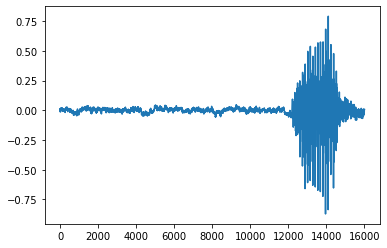

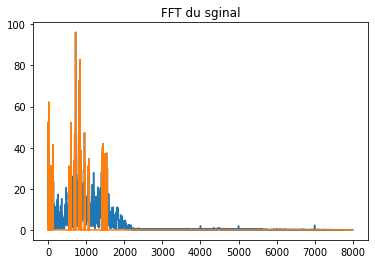

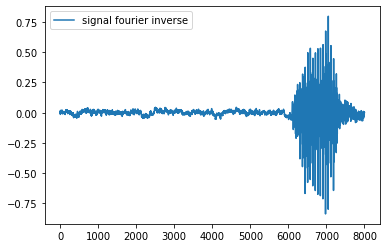

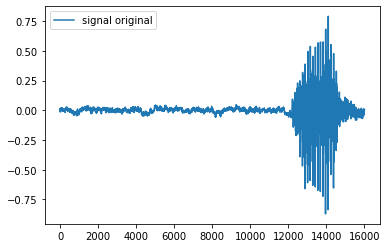

In [ ]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
import numpy as np
import numpy.fft as fft
import math

wv=waveform.t().numpy() 
wv-= wv.mean()
wv=wv.squeeze()
fe=16000

plt.plot(wv)
plt.figure()

spectrum = fft.rfft(wv)
freq = fft.rfftfreq(len(wv),d=1/fe)
plt.plot(freq,abs(spectrum))
plt.title('FFT du sginal')


#--------------------------------------------
threshold = 0.3 * max(abs(spectrum))
mask = abs(spectrum) > threshold
peaks = freq[mask]
spectrum_cleared=numpy.zeros_like(spectrum)
c=0
for i in range(len(mask)):
  if mask[i] :
    spectrum_cleared[i]=  abs ( spectrum[i] )
    
plt.plot(freq,spectrum_cleared)


plt.figure()
signal=np.fft.irfft(spectrum)
plt.plot( signal.real, label='signal fourier inverse')
plt.legend()
plt.figure()
plt.plot( waveform.t().numpy(),label='signal original')
plt.legend()

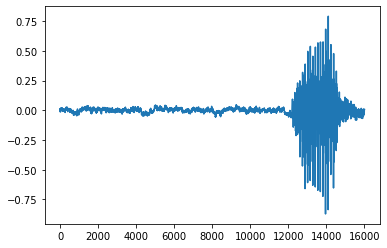

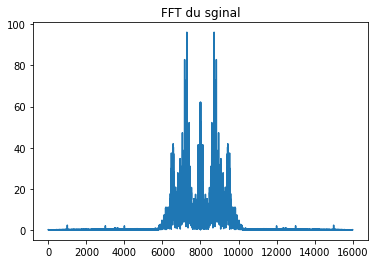

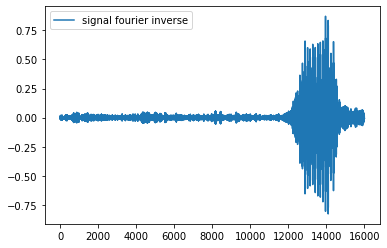

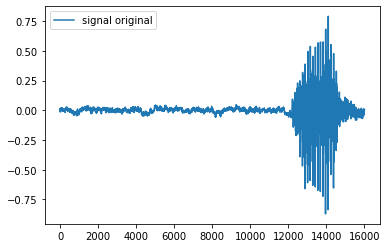

In [ ]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
import numpy as np
import numpy.fft as fft
import math

wv=waveform.t().numpy() 
wv-= wv.mean()
wv=wv.squeeze()
fe=16000

plt.plot(wv)
plt.figure()

spectrum = fft.fftshift( fft.fft(wv) )
freq = fft.fftfreq(len(wv),d=1/fe)
plt.plot(abs(spectrum))
plt.title('FFT du sginal')


#--------------------------------------------
'''threshold = 0.3 * max(abs(spectrum))
mask = abs(spectrum) > threshold
peaks = freq[mask]
spectrum_cleared=numpy.zeros_like(spectrum)
c=0
for i in range(len(mask)):
  if mask[i] :
    spectrum_cleared[i]=  abs ( spectrum[i] )
    
plt.plot(freq,spectrum_cleared)'''


plt.figure()
signal=np.fft.ifft(spectrum)
plt.plot( signal.real, label='signal fourier inverse')
plt.legend()
plt.figure()
plt.plot( waveform.t().numpy(),label='signal original')
plt.legend()

In [ ]:
maxValue=1
qt=maxValue
maxIt=5
c=0
for data in test_set :
  waveform,*_=data
  wv=waveform.t().numpy()
  wv = abs(wv-np.append( wv[1:] , 0))
  qt=min(qt,wv[wv !=0].min())
  c+=1
  if c==maxIt:
    break

qt=abs(qt)
print('minimum qt=',qt)

minimum qt= 3.0517578125e-05


In [ ]:
PossibleIntValue=int(2*maxValue/qt)
print('maximum integer value is ',PossibleIntValue)
nbits=math.log(PossibleIntValue)/math.log(2)
print('nbits=',math.ceil(nbits))
SNR=np.round(20*np.log10(2**nbits),2)
print('SNR=',SNR,'dB')


maximum integer value is  65536
nbits= 16
SNR= 96.33 dB


A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


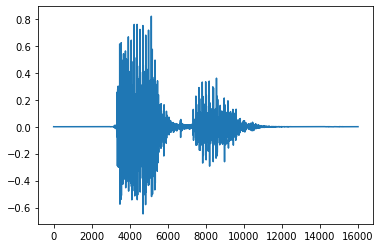

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))


In [ ]:
for l in labels :
  print(l,end=', ')

backward, bed, bird, cat, dog, down, eight, five, follow, forward, four, go, happy, house, learn, left, marvin, nine, no, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, visual, wow, yes, zero, 

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [ ]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)


In [ ]:
waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [ ]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the PDM_model network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [ ]:
class PDM_model(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = PDM_model(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

PDM_model(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)


In [ ]:
print('n input:',transformed.shape[0])
print('n output:',len(labels))

n input: 1
n output: 35


We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  0%|          | 0.002188183807439825/2 [00:00<02:57, 89.04s/it]

Train Epoch: 1 [0/105829 (0%)]	Loss: 3.711254


  2%|▏         | 0.045951859956236345/2 [00:04<02:59, 92.10s/it]

Train Epoch: 1 [5120/105829 (5%)]	Loss: 3.085478


  5%|▍         | 0.0919037199124726/2 [00:08<02:51, 90.11s/it] 

Train Epoch: 1 [10240/105829 (10%)]	Loss: 2.588547


  7%|▋         | 0.1334792122538292/2 [00:12<02:42, 87.03s/it] 

Train Epoch: 1 [15360/105829 (14%)]	Loss: 2.297068


  9%|▉         | 0.1772428884026256/2 [00:16<02:38, 87.19s/it] 

Train Epoch: 1 [20480/105829 (19%)]	Loss: 2.161274


 11%|█         | 0.22100656455142198/2 [00:19<02:46, 93.87s/it]

Train Epoch: 1 [25600/105829 (24%)]	Loss: 1.904175


 13%|█▎        | 0.26477024070021854/2 [00:23<02:37, 90.95s/it]

Train Epoch: 1 [30720/105829 (29%)]	Loss: 1.659262


 16%|█▌        | 0.31072210065645534/2 [00:27<02:19, 82.81s/it]

Train Epoch: 1 [35840/105829 (34%)]	Loss: 1.774090


 18%|█▊        | 0.3544857768052523/2 [00:31<02:18, 84.27s/it] 

Train Epoch: 1 [40960/105829 (39%)]	Loss: 1.541775


 20%|█▉        | 0.39824945295404923/2 [00:34<02:12, 82.59s/it]

Train Epoch: 1 [46080/105829 (43%)]	Loss: 1.513410


 22%|██▏       | 0.4420131291028462/2 [00:38<02:00, 77.30s/it] 

Train Epoch: 1 [51200/105829 (48%)]	Loss: 1.514612


 24%|██▍       | 0.48577680525164313/2 [00:41<02:04, 82.50s/it]

Train Epoch: 1 [56320/105829 (53%)]	Loss: 1.360993


 26%|██▋       | 0.5295404814004393/2 [00:45<01:59, 80.95s/it]

Train Epoch: 1 [61440/105829 (58%)]	Loss: 1.295744


 29%|██▊       | 0.5733041575492351/2 [00:48<01:53, 79.67s/it]

Train Epoch: 1 [66560/105829 (63%)]	Loss: 1.165607


 31%|███       | 0.617067833698031/2 [00:52<01:41, 73.56s/it] 

Train Epoch: 1 [71680/105829 (68%)]	Loss: 1.454715


 33%|███▎      | 0.6608315098468268/2 [00:55<01:32, 68.75s/it]

Train Epoch: 1 [76800/105829 (72%)]	Loss: 1.107076


 35%|███▌      | 0.7045951859956227/2 [00:58<01:27, 67.56s/it]

Train Epoch: 1 [81920/105829 (77%)]	Loss: 1.185130


 37%|███▋      | 0.7483588621444185/2 [01:01<01:22, 65.53s/it]

Train Epoch: 1 [87040/105829 (82%)]	Loss: 1.290119


 40%|███▉      | 0.7921225382932143/2 [01:03<01:15, 62.56s/it]

Train Epoch: 1 [92160/105829 (87%)]	Loss: 1.078005


 42%|████▏     | 0.8358862144420102/2 [01:06<01:09, 60.07s/it]

Train Epoch: 1 [97280/105829 (92%)]	Loss: 1.077419


 44%|████▍     | 0.879649890590806/2 [01:09<01:03, 56.77s/it] 

Train Epoch: 1 [102400/105829 (97%)]	Loss: 0.962857


 50%|█████     | 1.0043763676148743/2 [01:14<00:37, 38.05s/it]


Test Epoch: 1	Accuracy: 6604/11005 (60%)

Train Epoch: 2 [0/105829 (0%)]	Loss: 1.157729


 52%|█████▏    | 1.04814004376367/2 [01:16<00:38, 40.15s/it]  

Train Epoch: 2 [5120/105829 (5%)]	Loss: 0.913216


 55%|█████▍    | 1.091903719912466/2 [01:17<00:36, 40.02s/it] 

Train Epoch: 2 [10240/105829 (10%)]	Loss: 0.989619


 57%|█████▋    | 1.1356673960612618/2 [01:19<00:35, 40.82s/it]

Train Epoch: 2 [15360/105829 (14%)]	Loss: 0.888265


 59%|█████▉    | 1.1794310722100576/2 [01:21<00:33, 40.50s/it]

Train Epoch: 2 [20480/105829 (19%)]	Loss: 1.055384


 61%|██████    | 1.2231947483588534/2 [01:23<00:31, 40.17s/it]

Train Epoch: 2 [25600/105829 (24%)]	Loss: 0.887829


 63%|██████▎   | 1.2669584245076493/2 [01:24<00:29, 40.63s/it]

Train Epoch: 2 [30720/105829 (29%)]	Loss: 0.661918


 66%|██████▌   | 1.3107221006564451/2 [01:26<00:28, 40.78s/it]

Train Epoch: 2 [35840/105829 (34%)]	Loss: 0.925270


 68%|██████▊   | 1.354485776805241/2 [01:28<00:25, 39.29s/it] 

Train Epoch: 2 [40960/105829 (39%)]	Loss: 0.912506


 70%|██████▉   | 1.3982494529540368/2 [01:30<00:24, 40.67s/it]

Train Epoch: 2 [46080/105829 (43%)]	Loss: 0.901560


 72%|███████▏  | 1.4420131291028326/2 [01:32<00:22, 39.73s/it]

Train Epoch: 2 [51200/105829 (48%)]	Loss: 0.872281


 74%|███████▍  | 1.4857768052516285/2 [01:33<00:20, 39.36s/it]

Train Epoch: 2 [56320/105829 (53%)]	Loss: 0.882154


 76%|███████▋  | 1.5295404814004243/2 [01:35<00:19, 40.89s/it]

Train Epoch: 2 [61440/105829 (58%)]	Loss: 0.759774


 79%|███████▊  | 1.5733041575492202/2 [01:37<00:17, 40.73s/it]

Train Epoch: 2 [66560/105829 (63%)]	Loss: 0.868716


 81%|████████  | 1.617067833698016/2 [01:39<00:15, 40.57s/it] 

Train Epoch: 2 [71680/105829 (68%)]	Loss: 0.933081


 83%|████████▎ | 1.6608315098468118/2 [01:40<00:13, 40.34s/it]

Train Epoch: 2 [76800/105829 (72%)]	Loss: 0.849511


 85%|████████▌ | 1.7045951859956077/2 [01:42<00:11, 40.37s/it]

Train Epoch: 2 [81920/105829 (77%)]	Loss: 0.796971


 87%|████████▋ | 1.7483588621444035/2 [01:44<00:09, 39.15s/it]

Train Epoch: 2 [87040/105829 (82%)]	Loss: 0.792044


 90%|████████▉ | 1.7921225382931993/2 [01:46<00:08, 39.58s/it]

Train Epoch: 2 [92160/105829 (87%)]	Loss: 0.792836


 92%|█████████▏| 1.8358862144419952/2 [01:47<00:06, 38.42s/it]

Train Epoch: 2 [97280/105829 (92%)]	Loss: 0.835086


 94%|█████████▍| 1.879649890590791/2 [01:49<00:04, 39.31s/it] 

Train Epoch: 2 [102400/105829 (97%)]	Loss: 0.846813


100%|█████████▉| 1.9999999999999796/2 [01:53<00:00, 56.99s/it]


Test Epoch: 2	Accuracy: 8185/11005 (74%)



The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]


print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")
ipd.Audio(waveform.numpy(), rate=sample_rate)

Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.




In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

Data point #1. Expected: right. Predicted: three.


Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




In [ ]:
def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: down.


Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.




### On va essayer de visualiser les poids .

In [ ]:
def plotFFT(tensor,fe=8000,ax=None):
  tensor-= tensor.mean()
  if ax ==None:
    plt.figure()
  spectrum = fft.rfft(tensor)
  freq = fft.rfftfreq(len(tensor),d=1/fe)
  if ax ==None:
    plt.plot(freq,abs(spectrum))
    plt.show()
  else:
    ax.plot(freq,abs(spectrum))

def plot_kernels1D(tensor,FFT=False,fe=8000,plotName=False):
  if tensor.ndim==2:
    tensor=tensor[:,None,:]

  if not tensor.ndim==3:
      raise Exception("assumes a 3D tensor")
  num_kernels = tensor.shape[0]
  sep=int(np.ceil(np.sqrt(num_kernels)))
  fig = plt.figure(figsize=(sep, sep))
  for i in range(num_kernels):
    a=fig.add_subplot(sep, sep, i+1)
    if FFT :
      plotFFT(tensor[i,0],fe,ax=a)
    else:
      a.plot(tensor[i,0])
    a.axis('off')
    if plotName:
      a.set_title('kernel'+str(i))
  plt.show()

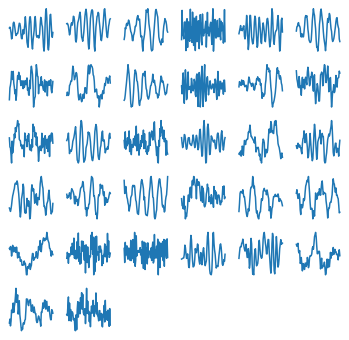

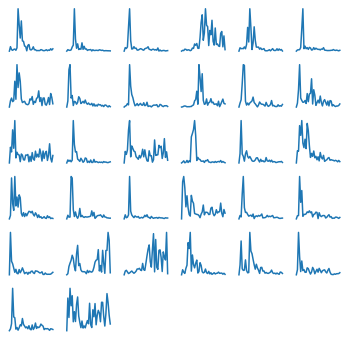

In [ ]:
FirstLayerWeights=model.conv1.weight.detach().numpy()
plot_kernels1D(FirstLayerWeights)
plot_kernels1D(FirstLayerWeights,True)

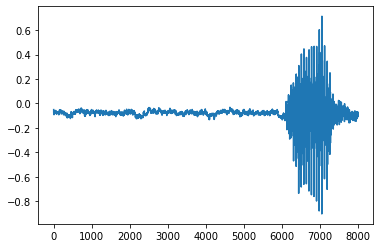

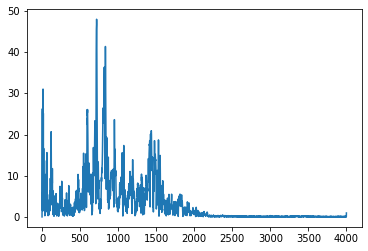

In [ ]:
data, *_ = train_set[0]
data=transform(data)
ts=model.conv1(data).detach().numpy()

plt.plot(data[0])
plotFFT(data[0])

(32, 496)


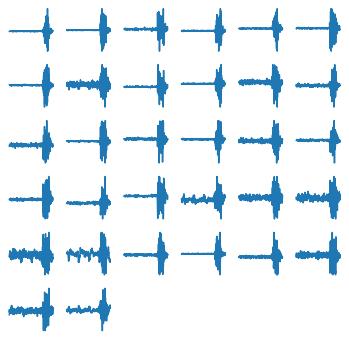

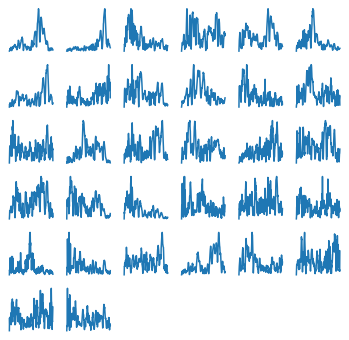

In [ ]:
print(ts.shape)
plot_kernels1D(ts)
plot_kernels1D(ts,True)